In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
scaler = MinMaxScaler()

def preprocessing(folder_name):
   # set file path
    folder_path = f'/content/drive/MyDrive/research/{folder_name}'

    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []
    # data_list = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path)

        #preprocessing column
        df = df.drop(['Date','Open','Close'], axis=1)
        df = df.rename(columns={'Adj Close':'Close'})
        df['Diff'] = df['High'] - df['Low']
        df = df.drop(['High','Low'], axis=1)

        #change 0 value to 0.000001
        df = df.replace(0, 0.000001)

        #log transform
        df = np.log(df)

        #using minmaxscaler of each column in df
        df[['Close','Volume','Diff']] = scaler.fit_transform(df[['Close','Volume','Diff']])

        #apply weight
        df['input'] = df['Close'] * 0.4 + df['Diff'] * 0.3 + df['Volume'] * 0.3

        #drop column
        df = df.drop(['Close','Volume','Diff'], axis=1)

        #dataframe to list
        df = df['input'].tolist()

        #insert list to array
        data_array.append(df)

    #list to numpy array and return
    return np.array(data_array)
        
        # save dataframe in variable without '.csv' extension
        # var_name = file.replace('.csv', '')
        # globals()[var_name] = df
        # data_list.append(var_name)

In [ ]:
#call preprocessing function
xGrowths = preprocessing('growth2000')
xValues = preprocessing('value2000')

<ipython-input-3-55c79a6a74fa>:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_array)
<ipython-input-3-55c79a6a74fa>:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_array)


In [ ]:
def bootstrap(data, n_samples):
    # generate bootstrap sample
    samples = []
    # sampling n_samples times
    for i in range(n_samples):
        # randomly sample from data with replacement
        sample = np.random.choice(data, size=1, replace=True)
        # append sample to ndarray
        samples = np.append(samples, sample)
    return samples

In [ ]:
n_samples = len(xValues) - len(xGrowths)
xGrowths_bootstrapped = bootstrap(xGrowths, n_samples)
xGrowths = np.concatenate((xGrowths, xGrowths_bootstrapped), axis=0)

In [ ]:
#generate y values
yGrowths = np.zeros(len(xGrowths))
yValues = np.ones(len(xValues))

In [ ]:
#concatenate growths and values
x = np.concatenate((xGrowths, xValues), axis=0)
y = np.concatenate((yGrowths, yValues), axis=0)

In [ ]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = splitData(x, y)

In [ ]:
# # to give more weight to minority class
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [ ]:
x_train = pad_sequences(x_train, dtype='float32')
x_test = pad_sequences(x_test, dtype='float32')

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
# model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history=model.fit(x_train, y_train, epochs=1000, batch_size=64, validation_split=0.2, callbacks=[es, mc])

Epoch 1/1000
27/27 [==============================] - 7s 133ms/step - loss: 0.6941 - acc: 0.4800 - val_loss: 0.6955 - val_acc: 0.4800
Epoch 2/1000
27/27 [==============================] - 3s 97ms/step - loss: 0.6944 - acc: 0.4929 - val_loss: 0.6932 - val_acc: 0.4847
Epoch 3/1000
27/27 [==============================] - 2s 82ms/step - loss: 0.6940 - acc: 0.4929 - val_loss: 0.6934 - val_acc: 0.4824
Epoch 4/1000
27/27 [==============================] - 2s 80ms/step - loss: 0.6935 - acc: 0.5088 - val_loss: 0.6950 - val_acc: 0.4800
Epoch 5/1000
27/27 [==============================] - 2s 84ms/step - loss: 0.6929 - acc: 0.5083 - val_loss: 0.6939 - val_acc: 0.4824
Epoch 6/1000
27/27 [==============================] - 2s 80ms/step - loss: 0.6931 - acc: 0.5071 - val_loss: 0.6938 - val_acc: 0.4776
Epoch 7/1000
27/27 [==============================] - 2s 92ms/step - loss: 0.6929 - acc: 0.5035 - val_loss: 0.6951 - val_acc: 0.4800
Epoch 8/1000
27/27 [==============================] - 3s 93ms/step -

In [ ]:
model=load_model('best_model.h5')
loss, accuracy = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)

# 각 테스트 케이스의 예측 클래스 레이블 추출
y_pred = np.argmax(y_pred_prob, axis=-1)

# 예측 클래스 레이블 출력
print(y_pred)

17/17 [==============================] - 1s 27ms/step
[1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0
 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0
 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1
 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0
 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1
 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1

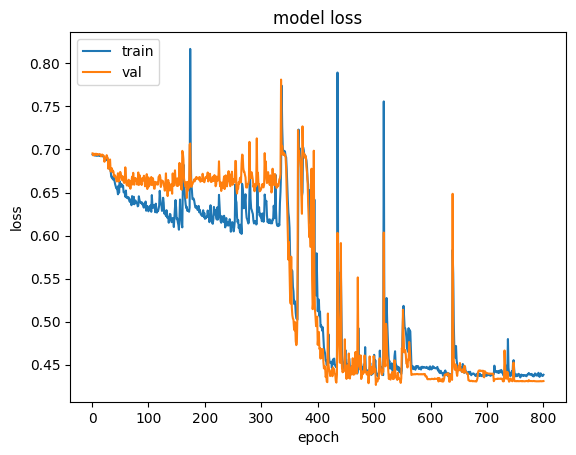

In [ ]:
# epochs = range(1, len(history.history['acc']) + 1)
epochs = range(1, 801)
plt.plot(epochs, history.history['loss'][:800])
plt.plot(epochs, history.history['val_loss'][:800])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
np.isnan(y_train).any()

False